# D* Lite Algorithm For Path Planning
Sven Koenig and Maxim Likhachev

Study done by:
- **Abhishek Gopinath Kovath (CB.EN.P2AID20002)**
- **Jiss Joseph Thomas (CB.EN.P2AID20024)**

References:
- Sven Koenig, Maxim Likhachev, “D* Lite”, AAAI,2002
- Howie Choset, “Robotic Motion Planning: A* and D* Search”, September 2007
- Joe Leavitt, Ben Ayton, Jessica Noss, Erlend Harbitz, Jake Barnwell & Sam Pinto, “Incremental Path Planning”, MIT OpenCourseWare, April 2016
- Jeffrey F. Zhang, Tony. Dear , “Dstar Lite: An Optimal Algorithm for Robotics Pathfinding”, October 2020
- Adrian Sotelo, “D * Lite and Dynamic Pathfinding”, Dipigen Institute of Technology, August 2016
- http://idm-lab.org/bib/abstracts/papers/aaai02b.pdf
- https://ocw.mit.edu/courses/aeronautics-and-astronautics/16-412j-cognitive-robotics-spring-2016/videos-for-advanced-lectures/advanced-lecture-1/

Application:
- Incremental dynamic path finding to traverse unknown terrain.

- The world around is unknown to the bot 
- It senses the world around it as it move toward the goal via the smallest path calculated.
- Untill it reaches its destination.

In [1]:
import matplotlib
import numpy as np
import heapq
%matplotlib notebook
from numpy.random import randint
import matplotlib.pyplot as plt
from dstarNode import Node

Class DStarLite:

In [2]:
class DStarLite: #The algorithm as it is
    def __init__(self, r_map, sx, sy, gx, gy): #initialise DStarLite
        self.start = np.array([sx, sy])
        self.goal = np.array([gx, gy])
        self.k_m = 0
        self.rhs = np.ones((r_map.shape[0], r_map.shape[1])) * np.inf
        self.g = self.rhs.copy()
        self.graph = r_map
        self.sensed_map = np.zeros((r_map.shape[0], r_map.shape[1]))
        self.rhs[self.goal[0], self.goal[1]] = 0
        self.queue = []
        node = Node(self.goal, *self.CalculateKey(self.goal))
        heapq.heappush(self.queue, node)

    # heuristic estimation
    def h_estimate(self, s1, s2):
        x_dist = s1[0] - s2[0]
        y_dist = s1[1] - s2[1]
        dist = np.sqrt(x_dist ** 2 + y_dist ** 2)
        return dist

    def CalculateKey(self, s):
        key = [0, 0]
        key[0] = min(self.g[s[0], s[1]], self.rhs[s[0], s[1]]) + self.h_estimate(self.start, s) + self.k_m
        key[1] = min(self.g[s[0], s[1]], self.rhs[s[0], s[1]])
        return key

    def UpdateVertex(self, u):
        if np.sum(np.abs(u - self.goal)) != 0:
            s_list = self.succ(u)
            min_s = []
            for s in s_list:
                min_s.append(self.cost(u, s) + self.g[s[0], s[1]])
            self.rhs[u[0], u[1]] = min(min_s)
        if Node(u, 0, 0) in self.queue:
            self.queue.remove(Node(u, 0, 0))
            heapq.heapify(self.queue)
        if self.g[u[0], u[1]] != self.rhs[u[0], u[1]]:
            heapq.heappush(self.queue, Node(u, *self.CalculateKey(u)))

    def ComputeShortestPath(self):
        while len(self.queue) > 0 and heapq.nsmallest(1, self.queue)[0] < Node(self.start, *self.CalculateKey(self.start)) or self.rhs[self.start[0], self.start[1]] != self.g[self.start[0], self.start[1]]:
            k_old = heapq.nsmallest(1, self.queue)[0]
            u = heapq.heappop(self.queue).key
            if k_old < Node(u, *self.CalculateKey(u)):
                heapq.heappush(self.queue, Node(u, *self.CalculateKey(u)))
            elif self.g[u[0], u[1]] > self.rhs[u[0], u[1]]:   #over consistent better value for g in rhs
                self.g[u[0], u[1]] = self.rhs[u[0], u[1]]
                s_list = self.succ(u)    #list of predessor
                for s in s_list:
                    self.UpdateVertex(s)
            else:   #under consistent
                self.g[u[0], u[1]] = np.inf
                s_list = self.succ(u)    #list of predessor
                s_list.append(u)
                for s in s_list:
                    self.UpdateVertex(s)

    # fetch successors and predessors in our case both are same
    def succ(self, u):
        s_list = [np.array([u[0] - 1, u[1] - 1]), np.array([u[0] - 1, u[1]]), np.array([u[0] - 1, u[1] + 1]),
                  np.array([u[0], u[1] - 1]), np.array([u[0], u[1] + 1]), np.array([u[0] + 1, u[1] - 1]),
                  np.array([u[0] + 1, u[1]]), np.array([u[0] + 1, u[1] + 1])]
        row = self.graph.shape[0]
        col = self.graph.shape[1]
        real_list = []
        for s in s_list:
            if 0 <= s[0] < row and 0 <= s[1] < col:
                real_list.append(s)
        return real_list

    # calculate cost between nodes
    def cost(self, u1, u2):
        if self.sensed_map[u1[0], u1[1]] == np.inf or self.sensed_map[u2[0], u2[1]] == np.inf:
            return np.inf
        else:
            return self.h_estimate(u1, u2)

    def sense(self, range_s):
        real_list = []
        row = self.graph.shape[0]
        col = self.graph.shape[1]
        for i in range(-range_s, range_s + 1):
            for j in range(-range_s, range_s + 1):
                if 0 <= self.start[0] + i < row and 0 <= self.start[1] + j < col:
                    if not (i == 0 and j == 0):
                        real_list.append(np.array([self.start[0] + i, self.start[1] + j]))
        return real_list

ScanAndUpdate Function to recalculate:

In [3]:
def ScanAndUpdate(present, last):
    s_list = present.sense(3)
    flag = False
    for s in s_list:
        if present.sensed_map[s[0], s[1]] != present.graph[s[0], s[1]]:
            flag = True
            print(f'See a obstacle at {s}')
            break
    if flag:
        present.k_m += present.h_estimate(last, present.start)
        last = present.start.copy()
        for s in s_list:
            if present.sensed_map[s[0], s[1]] != present.graph[s[0], s[1]]:
                plt.plot(s[0], s[1], 'xr')
                present.sensed_map[s[0], s[1]] = present.graph[s[0], s[1]]
                present.UpdateVertex(s)
        present.ComputeShortestPath()
    return last

Main Function:

<IPython.core.display.Javascript object>


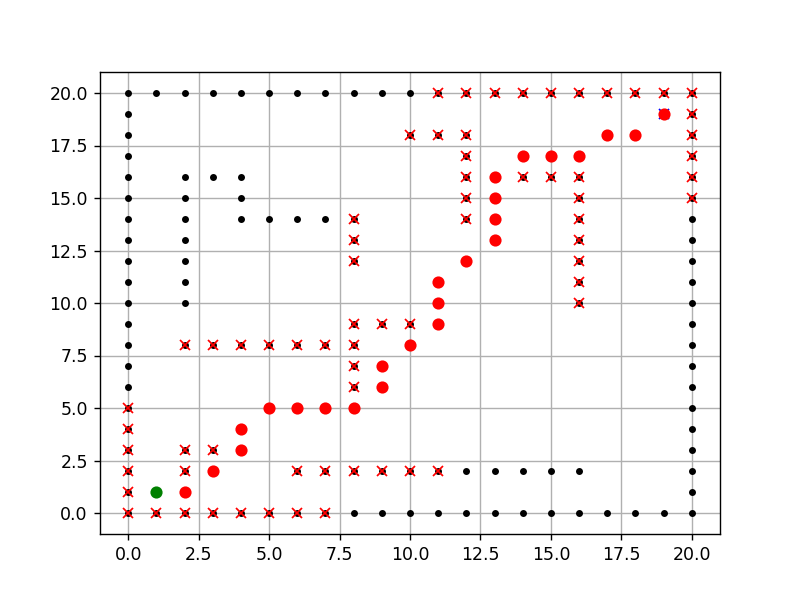

See a obstacle at [0 0]
Move to [2, 1]
See a obstacle at [5 0]
Move to [3, 2]
See a obstacle at [0 5]
Move to [4, 3]
See a obstacle at [7 0]
Move to [4, 4]
Move to [5, 5]
See a obstacle at [2 8]
Move to [6, 5]
See a obstacle at [9 2]
Move to [7, 5]
See a obstacle at [10  2]
Move to [8, 5]
See a obstacle at [11  2]
Move to [9, 6]
See a obstacle at [8 9]
Move to [9, 7]
Move to [10, 8]
Move to [11, 9]
See a obstacle at [ 8 12]
Move to [11, 10]
See a obstacle at [ 8 13]
Move to [11, 11]
See a obstacle at [ 8 14]
Move to [12, 12]
See a obstacle at [12 15]
Move to [13, 13]
See a obstacle at [12 16]
Move to [13, 14]
See a obstacle at [12 17]
Move to [13, 15]
See a obstacle at [10 18]
Move to [13, 16]
Move to [14, 17]
See a obstacle at [11 20]
Move to [15, 17]
See a obstacle at [18 20]
Move to [16, 17]
See a obstacle at [19 20]
Move to [17, 18]
See a obstacle at [20 15]
Move to [18, 18]
Move to [19, 19]
Goal Reached


In [4]:
if __name__ == "__main__":
#     set start and goal point
    sx = 1
    sy = 1
    gx = 19
    gy = 19

#     set obstable positions
    graph = np.array([[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 
                      [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 
                      [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0], 
                      [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0], 
                      [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0], 
                      [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 
                      [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 
                      [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 
                      [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 
                      [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 
                      [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], 
                      [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0], 
                      [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0], 
                      [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 
                      [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0], 
                      [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0], 
                      [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0], 
                      [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 
                      [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 
                      [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 
                      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])
#     print(graph)
    ox, oy = [], []
    for i in range(0, len(graph)):
        for j in range(0, len(graph[i])):
            if graph[i][j] == 1:
                ox.append(i)
                oy.append(j)

    graph[graph == 1] = np.inf
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.grid(True)
#     ax.plot([sx, gx], [sy, gy], 'r')
    ax.plot(ox, oy, ".k")
    ax.plot(sx, sy, "og")
    ax.plot(gx, gy, "xb")

#     Starting of Main()
    last = np.array([sx, sy])
    dstar = DStarLite(graph, sx, sy, gx, gy)
    last = ScanAndUpdate(dstar, last)
    dstar.ComputeShortestPath()
    while np.sum(np.abs(dstar.start - dstar.goal)) != 0:
        s_list = dstar.succ(dstar.start)
        min_s = np.inf
        for s in s_list:
#             plt.plot(s[0], s[1], 'xy')
            if dstar.cost(dstar.start, s) + dstar.g[s[0], s[1]] < min_s:
                min_s = dstar.cost(dstar.start, s) + dstar.g[s[0], s[1]]
                temp = s
        if min_s == np.inf:
            print("no path")
        dstar.start = temp
        print(f'Move to {[dstar.start[0],dstar.start[1]]}')
        ax.plot(dstar.start[0], dstar.start[1], 'or')
        fig.canvas.draw()
        last = ScanAndUpdate(dstar, last)
        plt.pause(0.05)
    print("Goal Reached")

    plt.show()